In [1]:
import pandas as pd
import numpy as np
import processing.scales as scales
import os

# define variable names
tia_scales = scales.tia_scales
hcsds_scales = scales.hcsds_scales
ati_scales = scales.ati_scales
manip_check_scales = scales.manip_check_scales

scale_titles = scales.scale_titles

plots_path = '../plots/multivariate_analysis/'

# Create output directory if it doesn't exist
output_path = '../output/'
os.makedirs(output_path, exist_ok=True)

# Load data
data = pd.read_csv('../data/data_scales.csv')
print(f"Total sample size: {len(data)}")
print(f"\nGroup distribution:")
print(data['stimulus_group'].value_counts())
print('\n')

# compute basic statistics for later tests
N = len(data)
p = len(tia_scales)
k = data['stimulus_group'].nunique()

# set alpha and power
alpha = 0.05
power = 0.80

print(f'Sample size: N = {N}')
print(f'Number of outcomes: p = {p}')
print(f'Number of groups: k = {k}')

Total sample size: 255

Group distribution:
stimulus_group
1    129
0    126
Name: count, dtype: int64


Sample size: N = 255
Number of outcomes: p = 5
Number of groups: k = 2


## Data Preparation

### Variable Centering and Coding

We prepare variables for moderation analysis:

1. **Effect code treatment**: stimulus_group as -0.5 (control) and 0.5 (uncertainty)
2. **Standardize continuous variables**: For better comparison of beta values between variables
3. **Effect code categorical variables**: For symmetric interpretation

In [2]:
# 1. Effect code treatment: control = -0.5, uncertainty = 0.5
data['group_effect'] = data['stimulus_group'] - 0.5

# 2. Normalize all continuous variables
continuous_vars = hcsds_scales + ati_scales + ['age', 'page_submit']

for var in continuous_vars:
    data[f'{var}_c'] = (data[var] - data[var].mean())/data[var].std()

# 3. Effect code gender: male (1) = 0.5, female (2) = -0.5, "other/prefer not to say" (3) = 0
data['gender_c'] = data['gender'].map({1: 0.5, 2: -0.5, 3: 0})

# 4. Mean-center ordinal variables (education, AI experience)
data['education_c'] = data['education'] - data['education'].mean()
data['ai_exp_c'] = data['ai_exp'] - data['ai_exp'].mean()
data.drop('ai_exp', axis=1)

demographics = ['age', 'gender', 'education', 'ai_exp']

demographics_c = [f'{s}_c' for s in demographics]
hcsds_scales_c = [f'{s}_c' for s in hcsds_scales]
ati_scales_c = [f'{s}_c' for s in ati_scales]

print(f"Prepared {len(data)} observations for analysis")
print(f"Continuous moderators: {len(continuous_vars)}")
print(f"Total moderators to test: {len(continuous_vars) + 3}")  # + gender, education, Q19

Prepared 255 observations for analysis
Continuous moderators: 5
Total moderators to test: 8


## Descriptive Statistics

Before running inferential tests, examine the data:
- Means, SDs, and ranges for each trust subscale by experimental condition
- Correlation matrix for the 5 TiA subscales (to see how they relate)
- Sample sizes per group

**Note**: We use the 5 core TiA subscales as DVs: `tia_f`, `tia_pro`, `tia_rc`, `tia_t`, `tia_up`

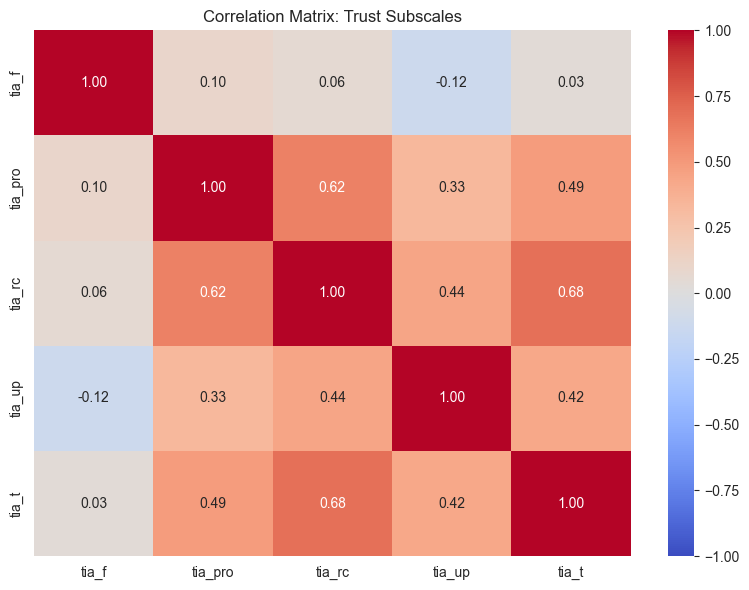

In [3]:
# Correlation matrix for DVs: Shows how the 5 trust subscales relate to each other
corr_matrix = data[tia_scales].corr()

# Visualize with heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix: Trust Subscales')
plt.tight_layout()
plt.savefig(f'{plots_path}tia_corr_matrix.png')
plt.show()

## Assumption Checks

MANOVA assumptions to verify:
1. **Univariate normality** - Shapiro-Wilk test + visual inspection (histograms, Q-Q plots)
2. **Multivariate outliers** - Mahalanobis distance (flag cases with p < .001)
3. **Homogeneity of covariance matrices** - Box's M test (if violated, use Pillai's Trace instead of Wilks' Lambda)
4. **Multicollinearity** - VIF for predictors (should be < 10, especially after adding interactions)

tia_f: W = 0.907, p = 0.000
tia_pro: W = 0.964, p = 0.000
tia_rc: W = 0.960, p = 0.000
tia_up: W = 0.978, p = 0.001
tia_t: W = 0.942, p = 0.000


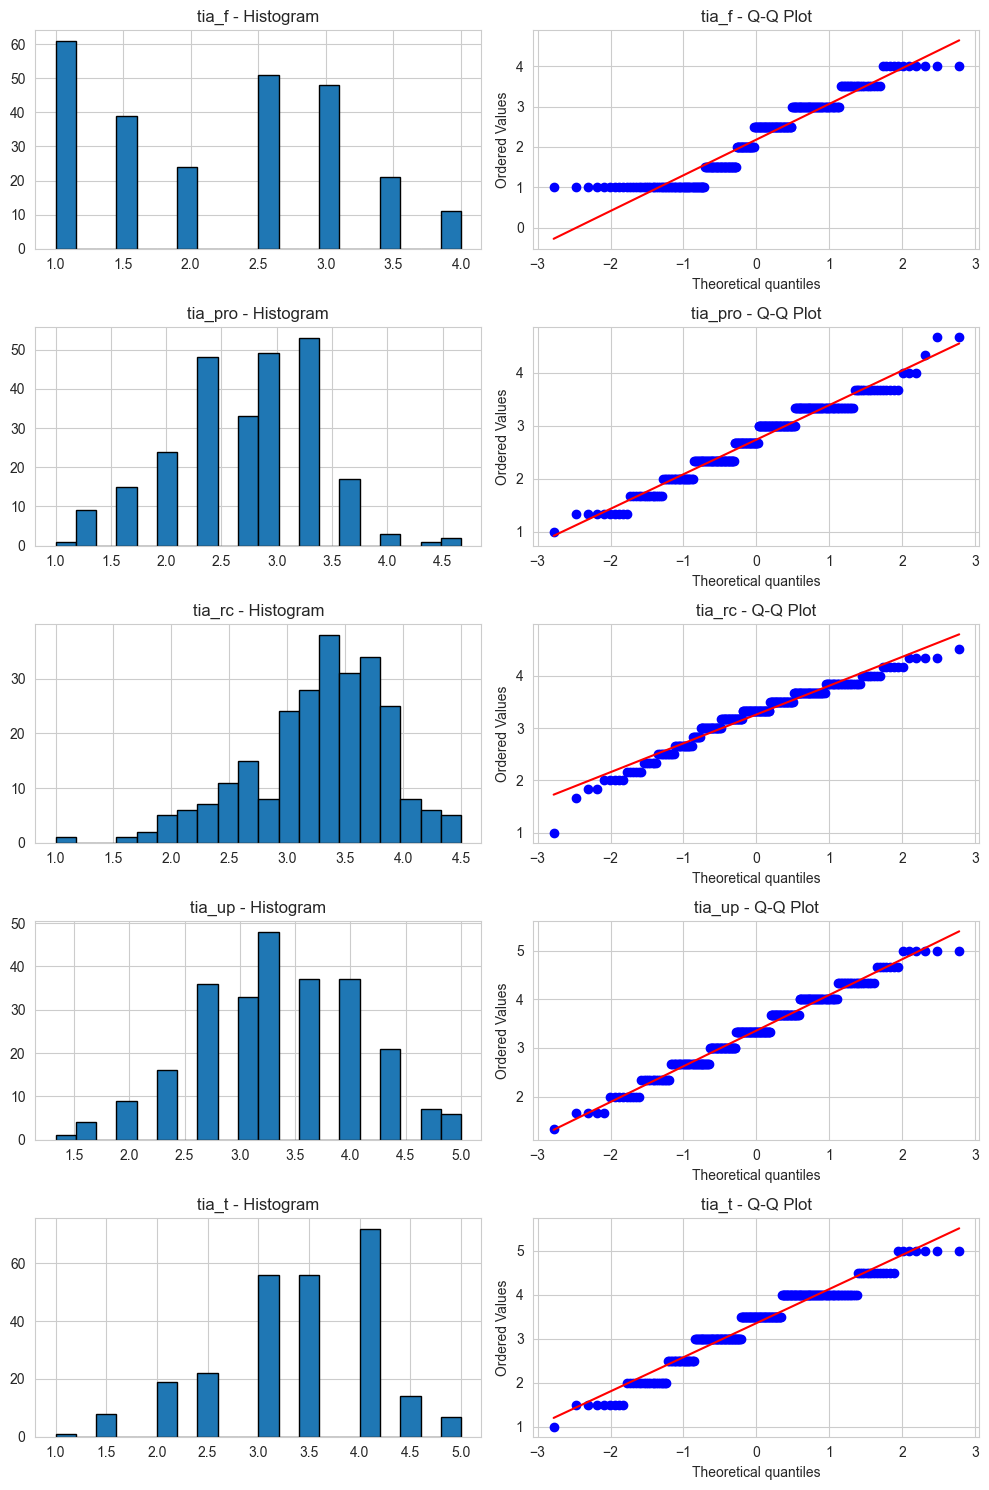

Multivariate outliers (p < .001): 1
       Variable       VIF
1  group_effect  1.008038
2         age_c  1.042640
3   education_c  1.076576
4         ati_c  1.011195
5     hcsds_c_c  1.611826
6     hcsds_v_c  1.553500


In [4]:
from scipy import stats
from scipy.spatial.distance import mahalanobis
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# --- 3.1 Univariate Normality ---
# Shapiro-Wilk test for each DV (p < .05 suggests non-normality)
for subscale in tia_scales:
    stat, pval = stats.shapiro(data[subscale])
    print(f"{subscale}: W = {stat:.3f}, p = {pval:.3f}")

# Visual: Histograms with Q-Q plots
fig, axes = plt.subplots(len(subscale), 2, figsize=(10, 3*len(subscale)))
for i, subscale in enumerate(tia_scales):
    axes[i, 0].hist(data[subscale], bins=20, edgecolor='black')
    axes[i, 0].set_title(f'{subscale} - Histogram')
    stats.probplot(data[subscale], plot=axes[i, 1])
    axes[i, 1].set_title(f'{subscale} - Q-Q Plot')
plt.tight_layout()
plt.savefig(f'{plots_path}tia_normality.png')
plt.show()

# --- 3.2 Multivariate Outliers (Mahalanobis Distance) ---
def calc_mahalanobis(df, vars):
    """Calculate Mahalanobis distance for each observation."""
    X = df[vars].values
    mean = np.mean(X, axis=0)
    cov = np.cov(X.T)
    cov_inv = np.linalg.inv(cov)
    distances = [mahalanobis(x, mean, cov_inv) for x in X]
    return distances

data['mahal_dist'] = calc_mahalanobis(data, tia_scales)
data['mahal_p'] = 1 - stats.chi2.cdf(data['mahal_dist']**2, df=len(tia_scales))
outliers = data[data['mahal_p'] < 0.001]
print(f"Multivariate outliers (p < .001): {len(outliers)}")

# --- 3.3 Homogeneity of Covariance (Box's M) ---
# Note: Box's M is sensitive to non-normality. If significant, use Pillai's Trace.
def boxs_m_test(data, dvs, group_var):
    """Manual Box's M test implementation."""
    # This is complex - consider using pingouin.box_m() or
    # just note to use Pillai's Trace if in doubt
    pass

# Alternative: Just use Pillai's Trace (more robust) by default

# --- 3.4 Multicollinearity (VIF) ---
# Check VIF for predictors in the full model
predictors = ['group_effect', 'age_c', 'education_c', 'ati_c', 'hcsds_c_c', 'hcsds_v_c']
X = data[predictors]
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data[vif_data['Variable'] != 'const'])

## Build MANOVA model

Use `statsmodels.multivariate.manova.MANOVA` for multivariate tests.

In [5]:
from statsmodels.multivariate.manova import MANOVA

# define families of effects here to use later for MCP correction
direct_effects = demographics_c + hcsds_scales_c + ati_scales_c
interaction_effects = [f'group_effect:{eff}' for eff in direct_effects]

formula = (f'{' + '.join(tia_scales)} ~ group_effect '
           f'+ {' + '.join(direct_effects)} '
           f'+ {' + '.join(interaction_effects)}')

manova_model = MANOVA.from_formula(formula, data=data)

In [6]:
# --- Extract test statistics from MANOVA results ---
# The mv_test() method returns a MultivariateTestResults object
# Access specific tests via: result.results['effect_name']['stat']

# df_e (within group df) = 'Den DF'
# df_h (between group df) = 'Num DF'

mv_results = []

r = manova_model.mv_test()

# go through all effects
for effect in r.results:
    print(f"\n=== {effect} ===")
    result_df = r.results[effect]['stat']
    pillai = result_df.loc["Pillai's trace"]

    print(f"Pillai's Trace = {pillai['Value']:.4f}")
    print(f"F({pillai['Num DF']:.0f}, {pillai['Den DF']:.0f}) = {pillai['F Value']:.3f}")

    # Calculate partial η² for multivariate effect
    partial_eta_sq = (pillai['F Value'] * pillai['Num DF']) / (pillai['F Value'] * pillai['Num DF'] + pillai['Den DF'])
    print(f"Partial eta2 = {partial_eta_sq:.4f}")

    # Calculate p-value and show marker for significance
    pval = pillai['Pr > F']
    sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''

    print(f"p = {pval:.4f} {sig}")

    mv_results.append({
        'effect': effect,
        'pillai value': pillai['Value'],
        'F Value': pillai['F Value'],
        'Num DF': pillai['Num DF'],
        'Den DF': pillai['Den DF'],
        'partial_eta_sq': partial_eta_sq,
        'p': pval,
    })

mv_results_df = pd.DataFrame(mv_results, index=[e['effect'] for e in mv_results]).drop('effect', axis=1)
mv_results_df.index.name = 'effect'

# show significant results
for i, row in mv_results_df[mv_results_df['p'] < 0.05].iterrows():
    print(f'{row.index}\n partial_eta2 = {row['partial_eta_sq']:.4f}  p = {row['p']:.4f}\n {'***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''}')


=== Intercept ===
Pillai's Trace = 0.9797
F(5, 235) = 2269.646
Partial eta2 = 0.9797
p = 0.0000 ***

=== group_effect ===
Pillai's Trace = 0.0198
F(5, 235) = 0.951
Partial eta2 = 0.0198
p = 0.4484 

=== age_c ===
Pillai's Trace = 0.1856
F(5, 235) = 10.712
Partial eta2 = 0.1856
p = 0.0000 ***

=== gender_c ===
Pillai's Trace = 0.0136
F(5, 235) = 0.648
Partial eta2 = 0.0136
p = 0.6632 

=== education_c ===
Pillai's Trace = 0.0713
F(5, 235) = 3.609
Partial eta2 = 0.0713
p = 0.0036 **

=== ai_exp_c ===
Pillai's Trace = 0.0720
F(5, 235) = 3.648
Partial eta2 = 0.0720
p = 0.0034 **

=== hcsds_c_c ===
Pillai's Trace = 0.0606
F(5, 235) = 3.031
Partial eta2 = 0.0606
p = 0.0114 *

=== hcsds_v_c ===
Pillai's Trace = 0.0315
F(5, 235) = 1.531
Partial eta2 = 0.0315
p = 0.1809 

=== ati_c ===
Pillai's Trace = 0.0913
F(5, 235) = 4.724
Partial eta2 = 0.0913
p = 0.0004 ***

=== group_effect:age_c ===
Pillai's Trace = 0.0543
F(5, 235) = 2.701
Partial eta2 = 0.0543
p = 0.0214 *

=== group_effect:gender_c 

### Multiple Comparisons Correction
- define "families" of variables: group, covariates, interactions
- apply correction method per family

In [7]:
CORRECTION_METHOD = 'holm'
############################

# define families
families = {
    'group': ['group_effect'],
    'direct': direct_effects,
    'interaction': interaction_effects
}

# correct p-values for multiple comparisons
from statsmodels.stats.multitest import multipletests
from scripts.utils import apa_p

p_vals_adj = {}
for fam in families.values():
    # get all relevant p values
    selection = pd.DataFrame(mv_results_df['p'].loc[fam].copy())

    # convert to adjusted p values
    adjusted = multipletests(selection['p'],
                             alpha=alpha,
                             method=CORRECTION_METHOD)[1]
    selection = selection.assign(p_val_adj=adjusted)

    # add to dictionary containing adjusted p-values
    for i, row in selection.iterrows():
        p_vals_adj[i] = row['p_val_adj']

mv_results_df['p_adj'] = p_vals_adj

p_adj_report = []
for i, row in mv_results_df.iterrows():
    p_adj_report.append(apa_p(row['p_adj'],
                                sig_stars=True))
mv_results_df['p_adj_report'] = p_adj_report

# remove '_c' for nicer reporting
mv_results_df.index = [s[:-2] if s[-2:] == '_c' else s for s in list(mv_results_df.index)]

mv_results_df.round(decimals=3).to_csv(f'{output_path}manova_results.csv', index=True)

mv_results_df

,pillai value,F Value,Num DF,Den DF,partial_eta_sq,p,p_adj,p_adj_report
Intercept,0.979712,2269.645593,5.0,235.0,0.979712,1.190060e-196,NaN,nan
group_effect,0.019843,0.951486,5.0,235.0,0.019843,4.484467e-01,4.484467e-01,.448
age,0.185618,10.712474,5.0,235.0,0.185618,2.738020e-09,1.916614e-08,< .001 ***
gender,0.013602,0.648101,5.0,235.0,0.013602,6.632181e-01,6.632181e-01,.663
education,0.071317,3.609306,5.0,235.0,0.071317,3.647316e-03,1.689747e-02,.017 *
ai_exp,0.072023,3.647834,5.0,235.0,0.072023,3.379493e-03,1.689747e-02,.017 *
hcsds_c,0.060578,3.030787,5.0,235.0,0.060578,1.135241e-02,3.405722e-02,.034 *
hcsds_v,0.031550,1.531149,5.0,235.0,0.031550,1.808566e-01,3.617133e-01,.362
ati,0.091330,4.723953,5.0,235.0,0.091330,3.939251e-04,2.363551e-03,.002 **
group_effect:age,0.054346,2.701030,5.0,235.0,0.054346,2.144895e-02,1.286937e-01,.129


## 5b. Multivariate Non-Inferiority Test (MANOVA)

Before testing each subscale individually, we can assess non-inferiority for the **collective set of trust outcomes** using a multivariate approach based on MANOVA.

In [8]:
# find MDE (minimally detectable effect) in a MANOVA
import numpy as np
from scipy.stats import f, ncf
from scipy.optimize import bisect

def mde_mannova(alpha, power, N, k, p):
    """
    Compute minimally detectable effect size for MANOVA.

    Parameters:
    -----------
    alpha : float - significance level
    power : float - desired power (1-β)
    N : int - total sample size
    k : int - number of groups
    p : int - number of dependent variables

    Returns:
    --------
    dict with effect sizes (Pillai's V, Cohen's f², partial η²)
    """

    # Step 1: Degrees of freedom
    df_h = k - 1
    df_e = N - k
    s = min(df_h, p)
    m = (abs(df_h - p) - 1) / 2
    n = (df_e - p - 1) / 2

    # Step 2: F-distribution df
    df1 = s * (2*m + s + 1)
    df2 = s * (2*n + s + 1)

    # Step 3: Critical F-value
    F_crit = f.ppf(1 - alpha, df1, df2)

    # Step 4: Find non-centrality parameter
    def power_diff(lambda_nc):
        computed_power = 1 - ncf.cdf(F_crit, df1, df2, lambda_nc)
        return computed_power - power

    # Search for lambda between 0 and 1000
    lambda_nc = bisect(power_diff, 0.001, 1000)

    # Step 5: Convert to effect sizes
    # Pillai's trace
    V = (lambda_nc * s) / (df_e + lambda_nc)

    # Cohen's f²
    f_squared = lambda_nc / N

    # Partial η²
    eta_squared_p = lambda_nc / (lambda_nc + df_e)

    return {
        'lambda': lambda_nc,
        'Pillais_V': V,
        'Cohens_f_squared': f_squared,
        'partial_eta_squared': eta_squared_p,
        'df1': df1,
        'df2': df2,
        'F_crit': F_crit
    }

# Example with your parameters
result = mde_mannova(
    alpha=alpha,
    power=power,
    N=N,
    k=k,
    p=p
)

eq_margin = result['partial_eta_squared']

print(f"Non-centrality parameter: {result['lambda']:.4f}")
print(f"Pillai's V: {result['Pillais_V']:.4f}")
print(f"Cohen's f²: {result['Cohens_f_squared']:.4f}")
print(f"Critical F: {result['F_crit']:.4f}")
print(f"Partial η²: {result['partial_eta_squared']:.4f}")

print(f'{'='*20}\nEquivalence margin: {eq_margin:.4f}')

Non-centrality parameter: 13.1152
Pillai's V: 0.0493
Cohen's f²: 0.0514
Critical F: 2.2503
Partial η²: 0.0493
Equivalence margin: 0.0493


In [9]:
from scripts.stats import eta_confidence_interval

def eta_ci_manova(F_obs, n, p, k=2, alpha=0.05):
    """
    Confidence interval for partial eta² (Pillai's V) from MANOVA.

    Parameters:
    -----------
    F_obs : float
        Observed F-value from MANOVA
    n : int
        Total sample size
    p : int
        Number of dependent variables
    k : int
        Number of groups (default 2)
    alpha : float
        Significance level (default 0.05)
    """
    return eta_confidence_interval(
        F_obs=F_obs,
        df1=p,
        df2=n - p - 1,
        df_error=n - k,
        alpha=alpha
    )


<>:28: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:28: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
C:\Users\tim20\AppData\Local\Temp\ipykernel_26252\2626216967.py:28: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
  xlabel='standardized effect size $\eta_{p}^{2}$',



Non-Inferiority Test Results for 'Multivariate
Effect':
  Effect size: 0.0198
  95% CI: [0.0000, 0.0438]
  SESOI margin: 0.0493
  (p-value: N/A)
  Result: Non-inferiority established



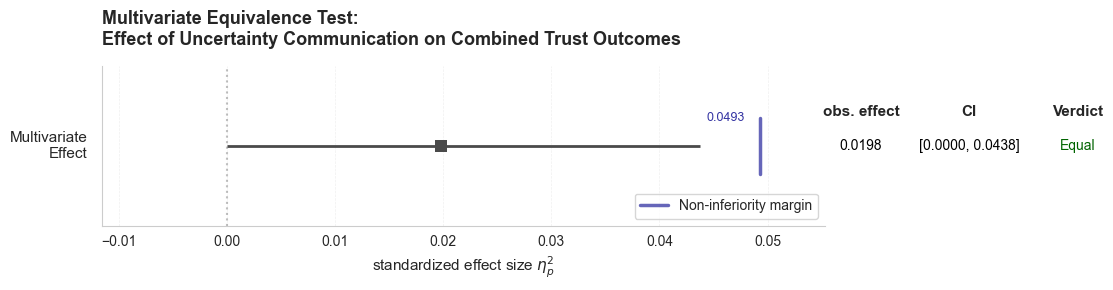

In [10]:
from scripts.viz_utils import plot_noninferiority_test

# Compute confidence interval around observed F value
F_obs = mv_results_df.loc['group_effect']['F Value']
eta_sq_obs = mv_results_df.loc['group_effect']['partial_eta_sq']

ci_results = eta_ci_manova(
    F_obs=F_obs,
    alpha=alpha,
    n=N,
    k=k,
    p=p
)

# Use pre-computed CI bounds from the eta_squared-distribution (not assuming normality)
fig, ax = plt.subplots(figsize=(12, 3))
ax = plot_noninferiority_test(
        effect_size=eta_sq_obs,
        sesoi=eq_margin,
        ci_lower_bounds=ci_results['eta_sq_lower'],  # Pre-computed from F-distribution
        ci_upper_bounds=ci_results['eta_sq_upper'],
        alpha=alpha,
        test_type='upper',
        mode = 'equivalence',
        variable_names=['multivariate'],
        variable_labels={'multivariate': 'Multivariate\nEffect'},
        title='Multivariate Equivalence Test:\nEffect of Uncertainty Communication on Combined Trust Outcomes',
        xlabel='standardized effect size $\eta_{p}^{2}$',
        estimate_name='obs. effect',
        height_scale=0.3,
        column_title_pos_shift=-0.2,
        ax=ax
    )

plt.tight_layout()
plt.savefig(f'{plots_path}multivariate_equivalence_test.png', dpi=150, transparent=True)
plt.show()

In [11]:
# save test statistics for combined plot
import json

eq_test_res = {
    'eta_sq_obs': eta_sq_obs,
    'ci_lower': ci_results['eta_sq_lower'],
    'ci_upper': ci_results['eta_sq_upper'],
    'eq_margin': eq_margin
}

with open(f'{output_path}multivariate_eq_test_res.json', 'w') as fp:
    json.dump(eq_test_res, fp, indent=4)